# Import libraries

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import squarify
import warnings
warnings.filterwarnings('ignore')


# Import data

In [187]:
transactions = pd.read_csv('Du_lieu_cung_cap/Transactions.csv')
products = pd.read_csv('Du_lieu_cung_cap/Products_with_Categories.csv')

In [188]:
# print table info
print('Transaction table')
print(transactions.info())
print(f'\nProducts table')
print(products.info())

Transaction table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Member_number  38765 non-null  int64 
 1   Date           38765 non-null  object
 2   productId      38765 non-null  int64 
 3   items          38765 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB
None

Products table
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    167 non-null    int64  
 1   productName  167 non-null    object 
 2   price        167 non-null    float64
 3   Category     167 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.3+ KB
None


In [189]:
# review first rows of tables
print('Transaction table')
print(transactions.head())
print(f'\nProducts table')
print(products.head())

Transaction table
   Member_number        Date  productId  items
0           1808  21-07-2015          1      3
1           2552  05-01-2015          2      1
2           2300  19-09-2015          3      3
3           1187  12-12-2015          4      3
4           3037  01-02-2015          2      1

Products table
   productId       productName  price         Category
0          1    tropical fruit    7.8       Fresh Food
1          2        whole milk    1.8            Dairy
2          3         pip fruit    3.0       Fresh Food
3          4  other vegetables    0.8       Fresh Food
4          5        rolls/buns    1.2  Bakery & Sweets


# Clean data

In [190]:
# check null values
print('Transaction table')
print(transactions.isnull().sum())
print(f'\nProducts table')
print(products.isnull().sum())

Transaction table
Member_number    0
Date             0
productId        0
items            0
dtype: int64

Products table
productId      0
productName    0
price          0
Category       0
dtype: int64


In [191]:
# check duplicated values
print('Transaction table')
print(transactions.duplicated().sum())
print(f'\nProducts table')
print(products.duplicated().sum())

Transaction table
244

Products table
0


In [192]:
# drop duplicated values
transactions.drop_duplicates(inplace=True)

In [193]:
# convert to date
string_to_date = lambda x : datetime.strptime(x, "%d-%m-%Y").date()
transactions['Date'] = transactions['Date'].apply(string_to_date)
transactions['Date'] = transactions['Date'].astype('datetime64[ns]')

# Merge 2 datasets

In [194]:
df = pd.merge(transactions, products, left_on='productId', right_on='productId')
df.head()

,Member_number,Date,productId,items,productName,price,Category
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy


# Data Exploration

## Basic check

In [195]:
print(f"Transactions are from {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of unique products: {df['productId'].nunique()}")
print(f"Number of unique members: {df['Member_number'].nunique()}")


Transactions are from 2014-01-01 00:00:00 to 2015-12-30 00:00:00
Number of unique products: 167
Number of unique members: 3898


In [196]:
# create new columns: sales = items x price
df['sales'] = df['items'] * df['price']

In [197]:
# define num & cat columns
num_cols = ['items','price', 'sales']
cat_cols = ['Category', 'productName']

In [198]:
# check unique values of num columns
for col in num_cols:
    if df[col].nunique() < 15:
        print(col, df[col].nunique(), df[col].unique())
    else:
        print(col, df[col].nunique())

items 3 [3 1 2]
price 90
sales 227


In [199]:
# check unique values of category column
for col in cat_cols:
    if df[col].nunique() < 15:
        print(col, df[col].nunique(), df[col].unique())
    else:
        print(col, df[col].nunique())

Category 11 ['Fresh Food' 'Dairy' 'Bakery & Sweets' 'Household & Hygiene' 'Beverages'
 'Frozen & Processed Food' 'Pantry Staples' 'Specialty & Seasonal'
 'Pet Care' 'Personal Care' 'Snacks']
productName 167


<Axes: xlabel='sales', ylabel='Density'>

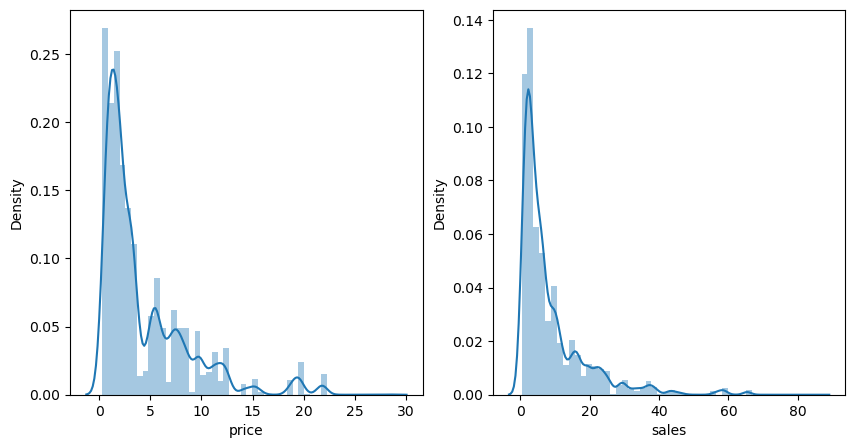

In [200]:
# distribution of price & sales
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(df['price'])

plt.subplot(1,2,2)
sns.distplot(df['sales'])


## Overview

In [201]:
df[['items','price','sales']].describe()

,items,price,sales
count,38521.000000,38521.000000,38521.000000
mean,1.996729,4.305367,8.590893
std,0.817539,4.320088,9.952770
min,1.000000,0.300000,0.300000
25%,1.000000,1.250000,2.400000
50%,2.000000,2.500000,5.200000
75%,3.000000,6.100000,10.500000
max,3.000000,28.500000,85.500000


In [202]:
df[['items','price','sales']].corr()

,items,price,sales
items,1.000000,-0.001630,0.353591
price,-0.001630,1.000000,0.864539
sales,0.353591,0.864539,1.000000


In [203]:
# create new column: month
df['month_start'] = df['Date'].dt.to_period('M').dt.to_timestamp()

In [204]:
# create new table: items & sales by month
items_monthly = df.groupby('month_start').agg({'items':'sum', 'sales':'sum'}).reset_index()

In [205]:
import matplotlib.dates as mdates

def dual_axis_chart(df, x, y1, y2, title, xlabel, y1_label='Revenue', y2_label='Items Sold'):
    df['month_start'] = df['month_start'].astype(str)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar chart for Items Sold
    sns.barplot(data=df, x=x, y=y2, ax=ax1, color='mediumseagreen', label=y2_label)
    ax1.set_ylabel(y2_label, color='mediumseagreen')
    ax1.tick_params(axis='y', labelcolor='mediumseagreen')

    # Create second y-axis for Revenue
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x=x, y=y1, ax=ax2, color='royalblue', marker='o', label=y1_label)
    ax2.set_ylabel(y1_label, color='royalblue')
    ax2.tick_params(axis='y', labelcolor='royalblue')
 
    
    # beautify legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='upper left')  # You can change the position if needed


    # Titles and layout
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylim(top=10000)
    fig.tight_layout()
    plt.ylim(bottom=0)
    # rotate x axis
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    plt.show()

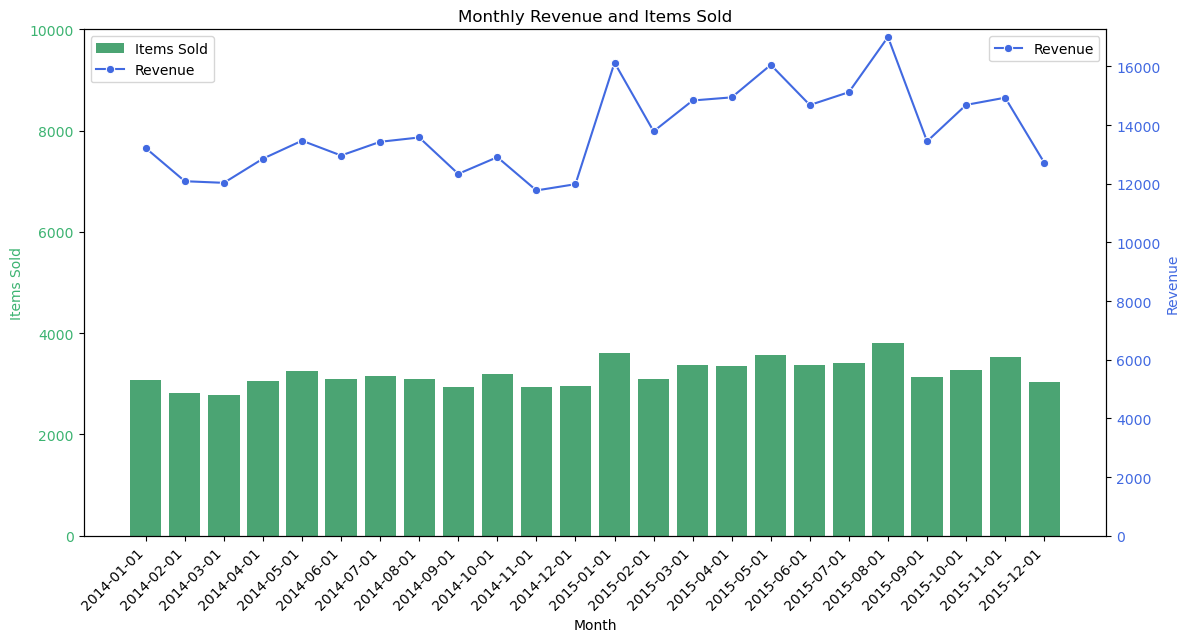

In [206]:
dual_axis_chart(
    df=items_monthly,
    x='month_start',
    y1='sales',
    y2='items',
    title='Monthly Revenue and Items Sold',
    xlabel='Month'
)

Highest revenue in Jan 2015 & July 2015

In [207]:
# Get top 10 products by items sold per month
top_10_monthly = (
    df.groupby(['month_start', 'productName'])[['items', 'sales']]
    .sum()
    .reset_index()
    .sort_values(['month_start', 'items'], ascending = [True, False])
)
top_10_monthly = top_10_monthly.groupby('month_start').head(10)
top_10_monthly.head(5)

,month_start,productName,items,sales
103,2014-01-01,rolls/buns,172,206.4
136,2014-01-01,whole milk,166,298.8
86,2014-01-01,other vegetables,131,104.8
116,2014-01-01,soda,125,100.0
137,2014-01-01,yogurt,91,200.2


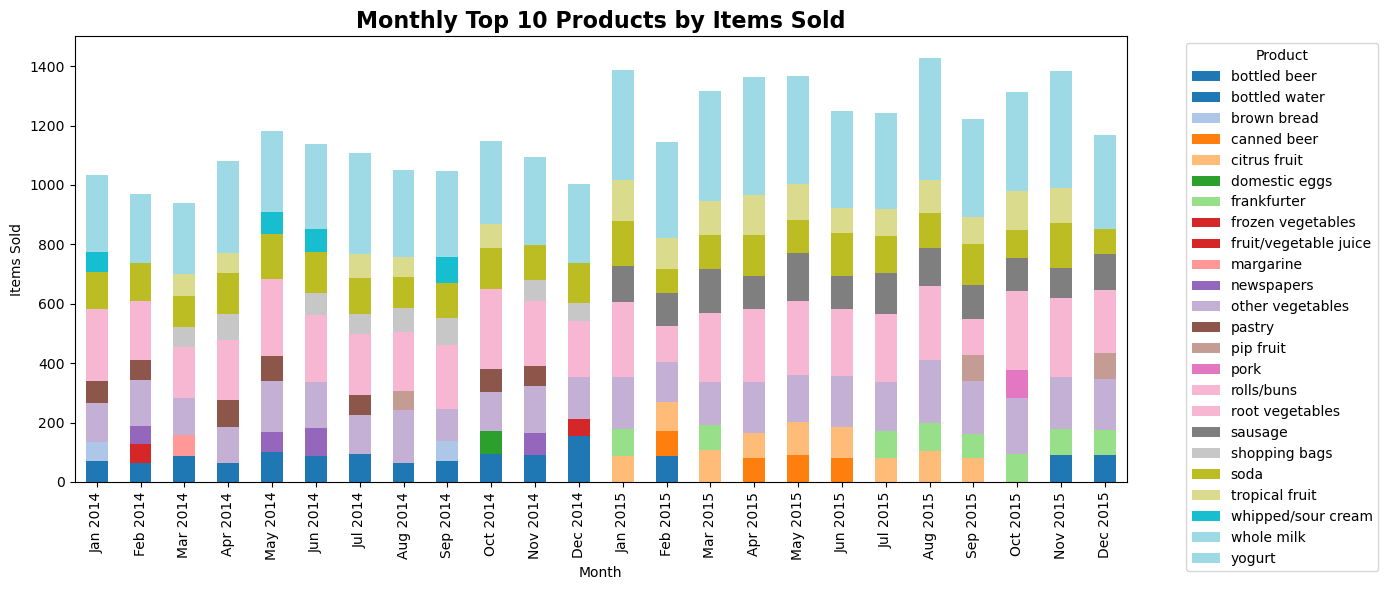

In [208]:

stacked_df = top_10_monthly.pivot(index='month_start', columns='productName', values='items').fillna(0)

#format the month for readibility
stacked_df.index = stacked_df.index.strftime('%b %Y')

stacked_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')

plt.title('Monthly Top 10 Products by Items Sold', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('Items Sold')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


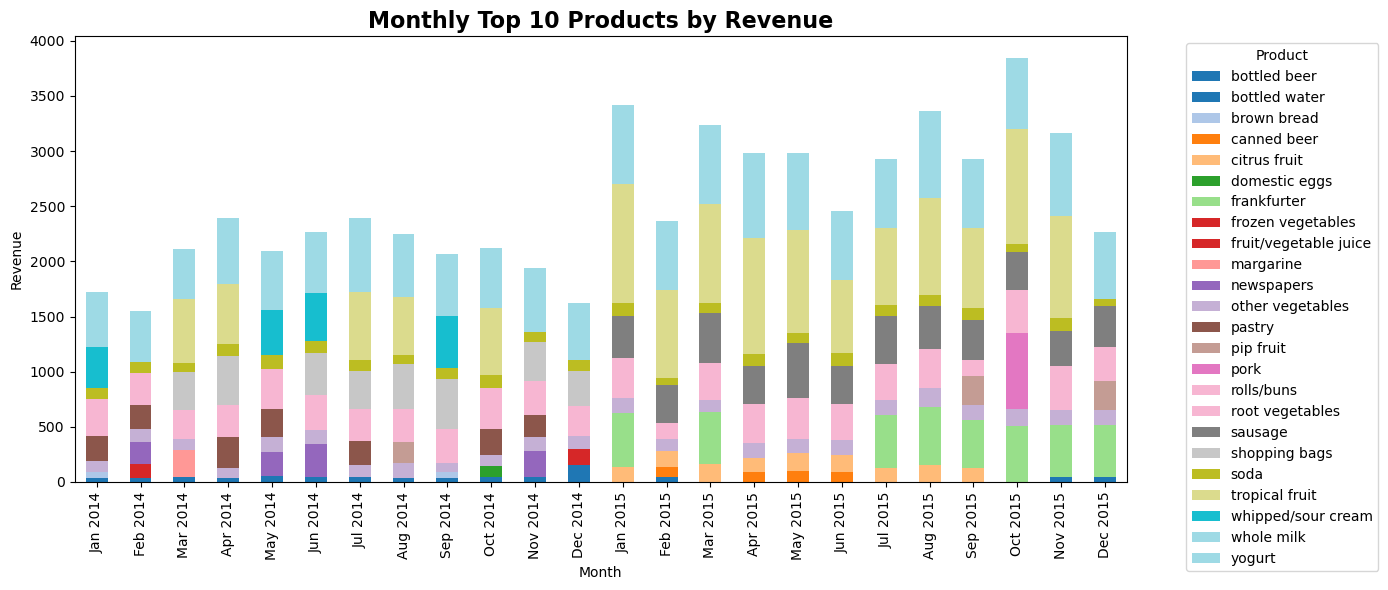

In [209]:

stacked_df = top_10_monthly.pivot(index='month_start', columns='productName', values='sales').fillna(0)

#format the month for readibility
stacked_df.index = stacked_df.index.strftime('%b %Y')

stacked_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')

plt.title('Monthly Top 10 Products by Revenue', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [210]:
# Get top 10 products by category per month
top_10_cat_monthly = (
    df.groupby(['month_start', 'Category'])[['items', 'sales']]
    .sum()
    .reset_index()
    .sort_values(['month_start', 'items'], ascending = [True, False])
)
top_10_cat_monthly = top_10_cat_monthly.groupby('month_start').head(10)
top_10_cat_monthly.head(5)

,month_start,Category,items,sales
3,2014-01-01,Fresh Food,685,3506.70
2,2014-01-01,Dairy,598,2465.64
0,2014-01-01,Bakery & Sweets,585,1918.56
1,2014-01-01,Beverages,460,1472.40
5,2014-01-01,Household & Hygiene,220,1787.20


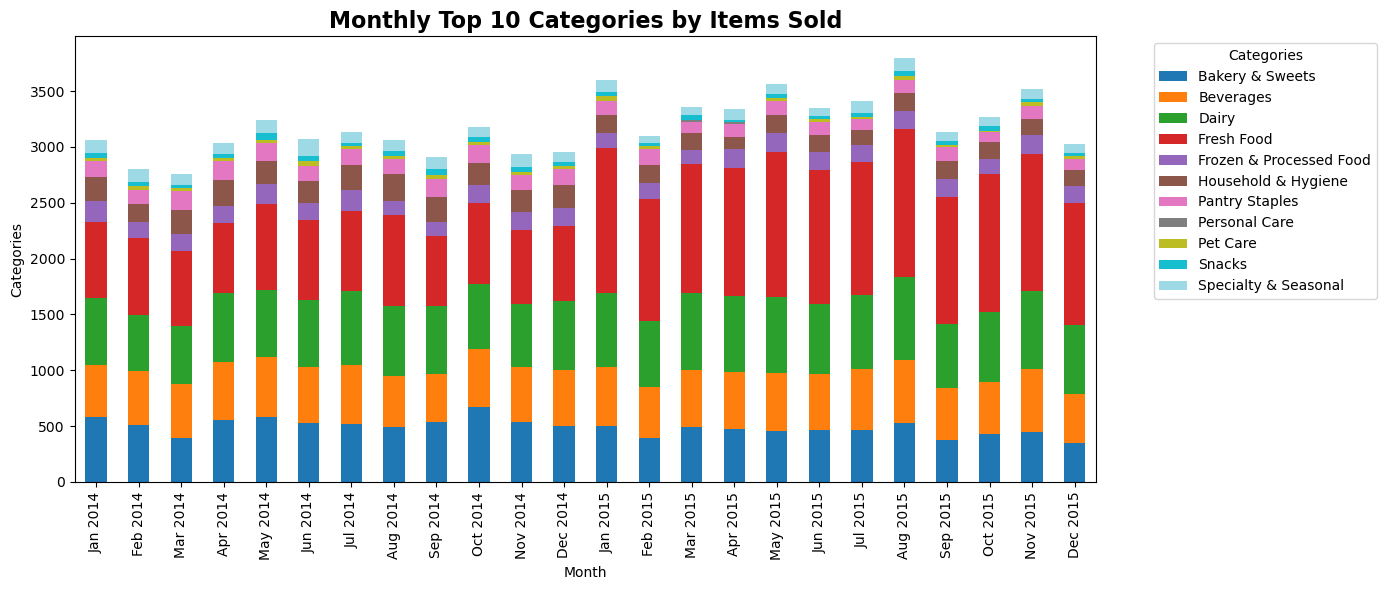

In [211]:
stacked_df = top_10_cat_monthly.pivot(index='month_start', columns='Category', values='items').fillna(0)

#format the month for readibility
stacked_df.index = stacked_df.index.strftime('%b %Y')

stacked_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')

plt.title('Monthly Top 10 Categories by Items Sold', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('Categories')
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


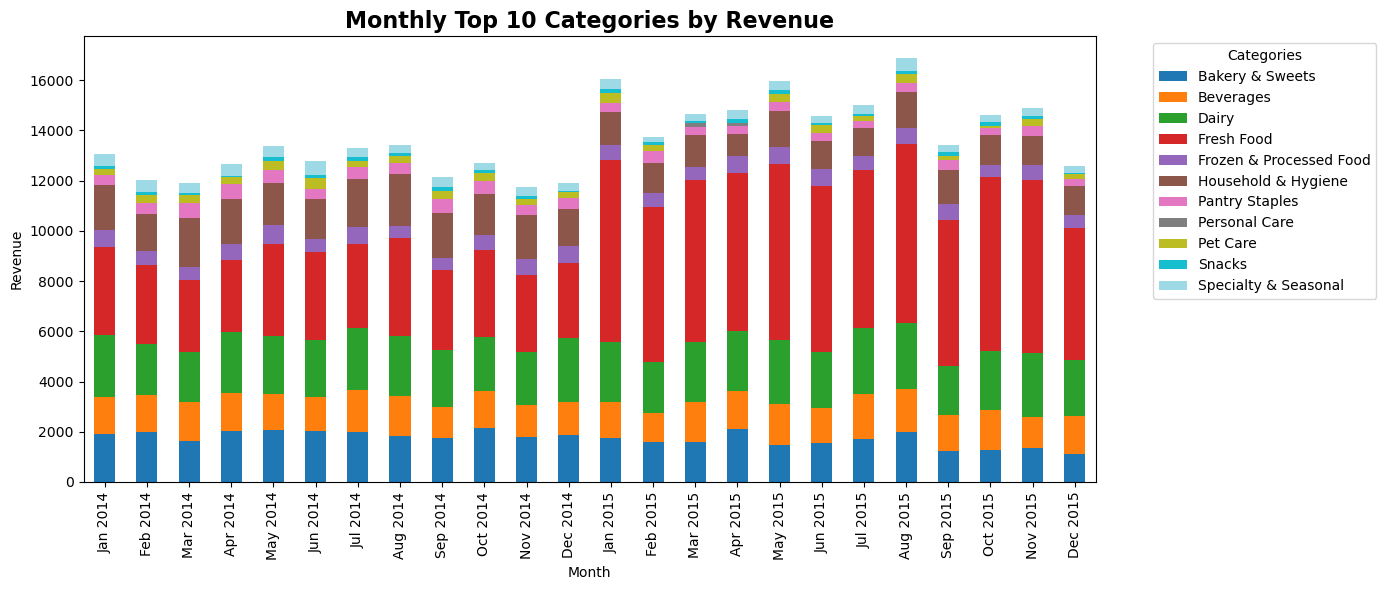

In [212]:
stacked_df = top_10_cat_monthly.pivot(index='month_start', columns='Category', values='sales').fillna(0)

#format the month for readibility
stacked_df.index = stacked_df.index.strftime('%b %Y')

stacked_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')

plt.title('Monthly Top 10 Categories by Revenue', fontsize=16, weight='bold')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Category Level

In [213]:
cat_items_sold = df.groupby('Category').agg(
            {'items': 'sum'}).sort_values(by = 'items', ascending=False)
cat_revenue_sold = df.groupby('Category').agg(
            {'sales': 'sum'}).sort_values(by = 'sales', ascending=False)
cat_price = df.groupby('Category').agg(
            {'price': 'mean'}).sort_values(by = 'price', ascending=False)

top_cat_sold = cat_items_sold.head(10)
top_cat_revenue = cat_revenue_sold.head(10)
top_cat_price = cat_price.head(10)


bottom_cat_sold = cat_items_sold.tail(10).sort_values(by = 'items')
bottom_cat_revenue = cat_revenue_sold.tail(10).sort_values(by = 'sales')
bottom_cat_price = cat_price.tail(10).sort_values(by = 'price')

In [214]:
def bar_h(df,x,y, title, xlabel, ylabel):
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x = x, y =y, palette='crest')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [215]:
def pareto_chart(df, x, y, title, xlabel, ylabel):
    # Sort by descending y values
    df_sorted = df.sort_values(by=y, ascending=False).reset_index(drop=True)

    # Calculate cumulative percent
    df_sorted['cumulative_percent'] = df_sorted[y].cumsum() / df_sorted[y].sum() * 100

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar chart
    sns.barplot(data=df_sorted, x=x, y=y, palette='crest', ax=ax1)
    ax1.set_ylabel(ylabel, color='tab:blue')
    ax1.set_xlabel(xlabel)
    ax1.set_title(title)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Line chart on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(df_sorted[x], df_sorted['cumulative_percent'], color='tab:red', marker='o', label='Cumulative %')
    ax2.set_ylabel('Cumulative %', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 110)

    # Optional: horizontal line at 80% (Pareto principle)
    ax2.axhline(80, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()


In [216]:
top_cat_sold.reset_index().columns

Index(['Category', 'items'], dtype='object')

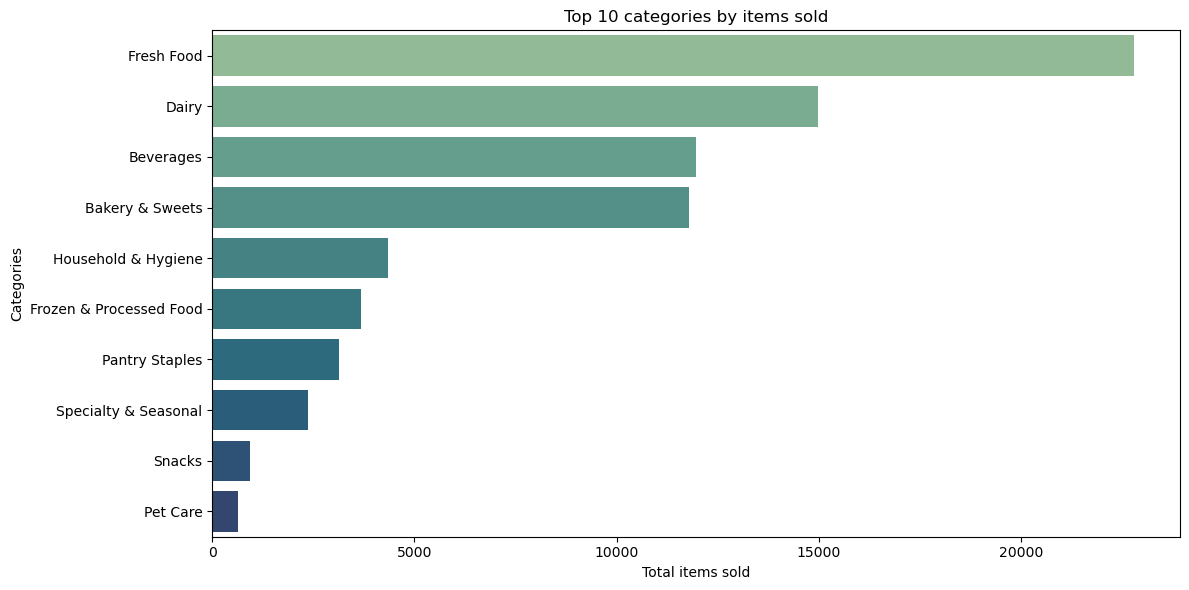

Top-selling categories 
                         items
Category                      
Fresh Food               22786
Dairy                    14968
Beverages                11963
Bakery & Sweets          11796
Household & Hygiene       4339
Frozen & Processed Food   3689
Pantry Staples            3134
Specialty & Seasonal      2360
Snacks                     928
Pet Care                   641 

Least-selling categories
                         items
Category                      
Personal Care              312
Pet Care                   641
Snacks                     928
Specialty & Seasonal      2360
Pantry Staples            3134
Frozen & Processed Food   3689
Household & Hygiene       4339
Bakery & Sweets          11796
Beverages                11963
Dairy                    14968


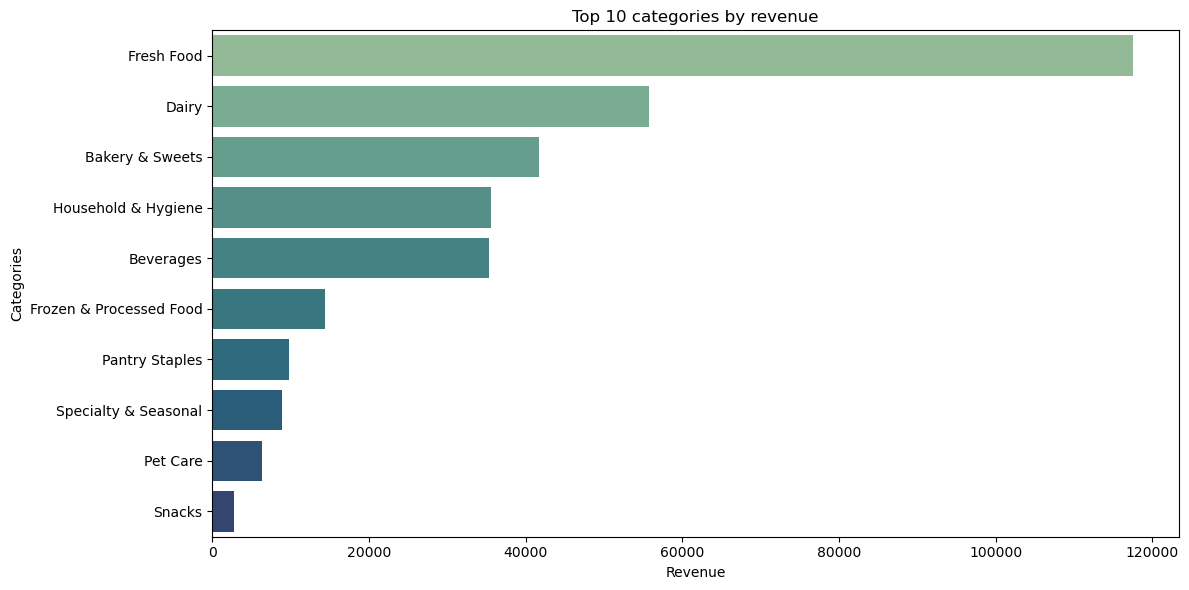

Top-selling categories 
                             sales
Category                          
Fresh Food               117566.20
Dairy                     55748.24
Bakery & Sweets           41780.78
Household & Hygiene       35555.16
Beverages                 35391.10
Frozen & Processed Food   14371.92
Pantry Staples             9857.45
Specialty & Seasonal       8864.30
Pet Care                   6425.80
Snacks                     2727.40 

Least-selling categories
                            sales
Category                         
Personal Care             2641.45
Snacks                    2727.40
Pet Care                  6425.80
Specialty & Seasonal      8864.30
Pantry Staples            9857.45
Frozen & Processed Food  14371.92
Beverages                35391.10
Household & Hygiene      35555.16
Bakery & Sweets          41780.78
Dairy                    55748.24


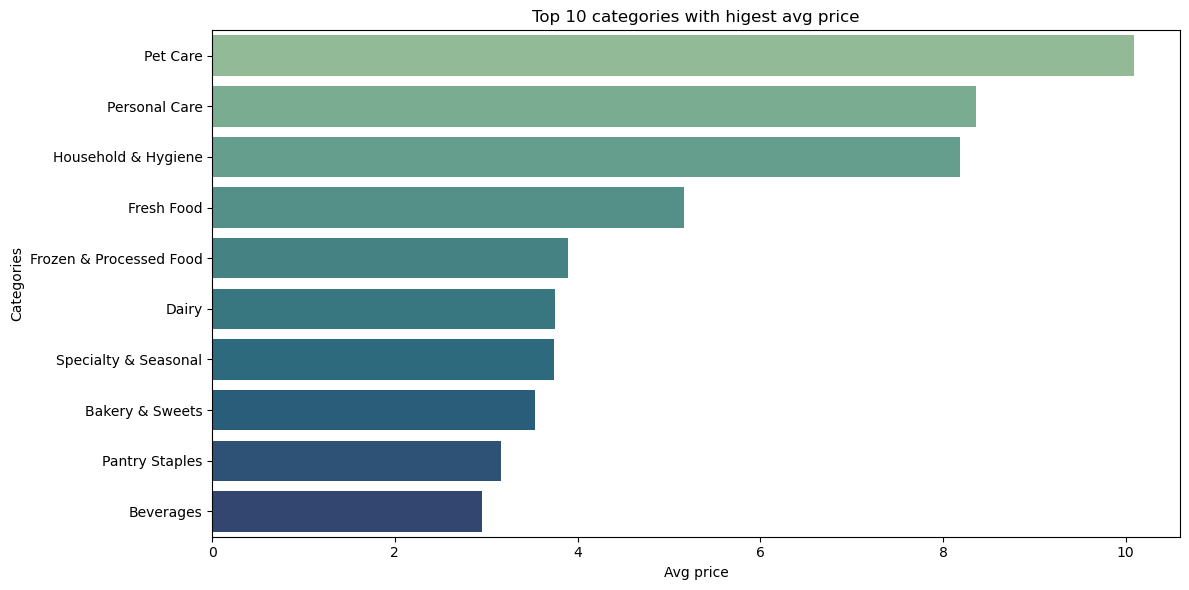

Top-selling categories 
                             price
Category                          
Pet Care                 10.089970
Personal Care             8.357643
Household & Hygiene       8.191337
Fresh Food                5.162809
Frozen & Processed Food   3.899152
Dairy                     3.753514
Specialty & Seasonal      3.740641
Bakery & Sweets           3.532947
Pantry Staples            3.162749
Beverages                 2.948519 

Least-selling categories
                            price
Category                         
Snacks                   2.770339
Beverages                2.948519
Pantry Staples           3.162749
Bakery & Sweets          3.532947
Specialty & Seasonal     3.740641
Dairy                    3.753514
Frozen & Processed Food  3.899152
Fresh Food               5.162809
Household & Hygiene      8.191337
Personal Care            8.357643


In [217]:
bar_h(top_cat_sold, 'items', 'Category','Top 10 categories by items sold', 'Total items sold', 'Categories' )
print(f"Top-selling categories \n{top_cat_sold} \n\nLeast-selling categories\n{bottom_cat_sold}")

bar_h(top_cat_revenue, 'sales', 'Category','Top 10 categories by revenue', 'Revenue', 'Categories' )
print(f"Top-selling categories \n{top_cat_revenue} \n\nLeast-selling categories\n{bottom_cat_revenue}")

bar_h(top_cat_price, 'price', 'Category','Top 10 categories with higest avg price', 'Avg price', 'Categories' )
print(f"Top-selling categories \n{top_cat_price} \n\nLeast-selling categories\n{bottom_cat_price}")


## Product Level

In [218]:
## Top products sold & revenue
products_items_sold = df.groupby('productName').agg(
            {'items': 'sum'}).sort_values(by = 'items', ascending=False)
products_revenues_sold = df.groupby('productName').agg(
            {'sales': 'sum'}).sort_values(by = 'sales', ascending=False)
products_price = df.groupby('productName').agg(
            {'price': 'mean'}).sort_values(by = 'price', ascending=False)

top_products_sold = products_items_sold.head(10)
top_products_revenue = products_revenues_sold.head(10)
top_products_price = products_price.head(10)

bottom_products_sold = products_items_sold.tail(10).sort_values(by = 'items')
bottom_products_revenue = products_revenues_sold.tail(10).sort_values(by = 'sales')
bottom_products_price = products_price.tail(10).sort_values(by = 'price')

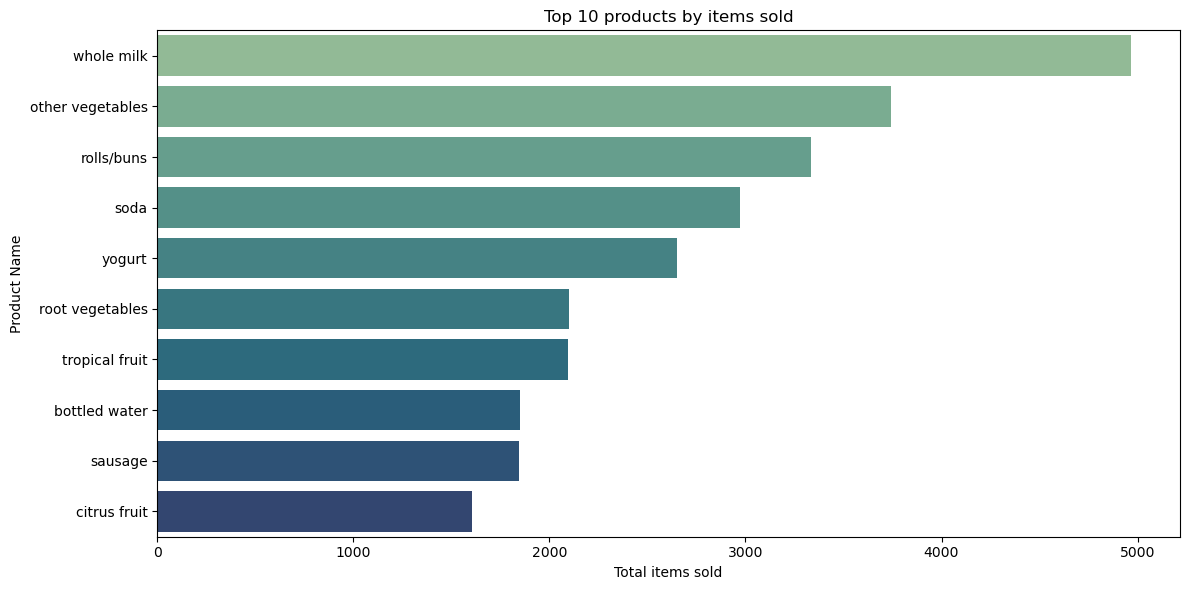

Top-selling products 
                  items
productName            
whole milk         4968
other vegetables   3743
rolls/buns         3332
soda               2970
yogurt             2650
root vegetables    2102
tropical fruit     2094
bottled water      1851
sausage            1846
citrus fruit       1605 

Least-selling products
                       items
productName                 
kitchen utensil            1
preservation products      2
bags                       5
make up remover            7
baby cosmetics             8
salad dressing            10
toilet cleaner            11
rubbing alcohol           11
frozen chicken            13
whisky                    16


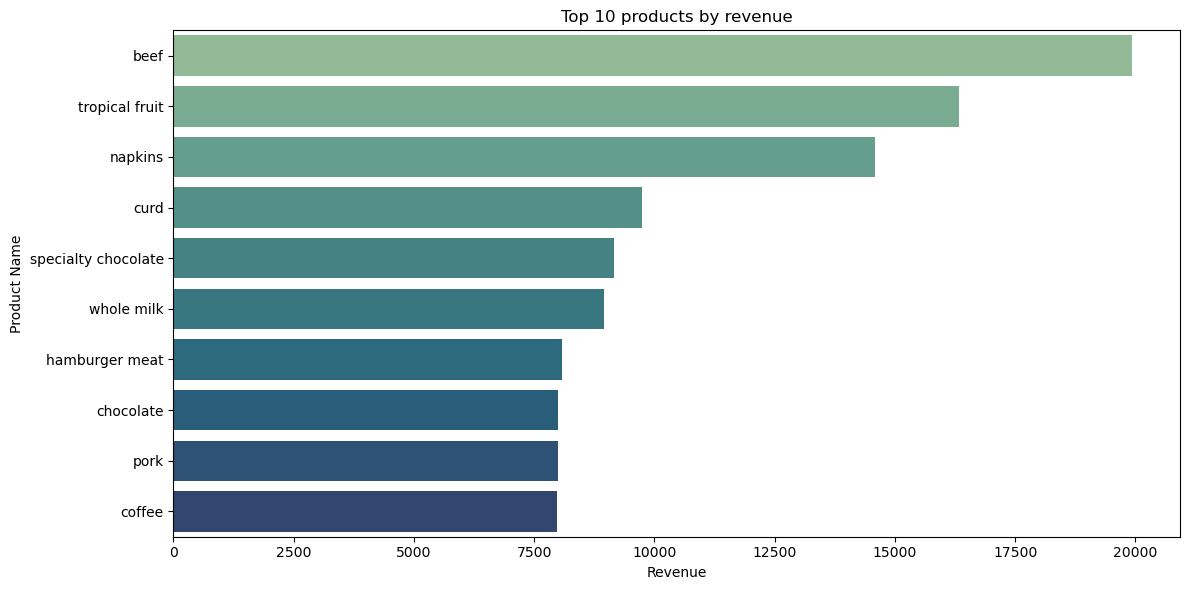

Top-selling products 
                       sales
productName                 
beef                 19929.0
tropical fruit       16333.2
napkins              14584.2
curd                  9731.4
specialty chocolate   9155.6
whole milk            8942.4
hamburger meat        8081.1
chocolate             7992.5
pork                  7984.8
coffee                7973.0 

Least-selling products
                       sales
productName                 
kitchen utensil          8.1
preservation products   13.5
make up remover         23.8
rubbing alcohol         27.5
frozen chicken          45.5
snack products          49.5
decalcifier             50.4
tidbits                 51.7
toilet cleaner          53.9
salad dressing          59.0


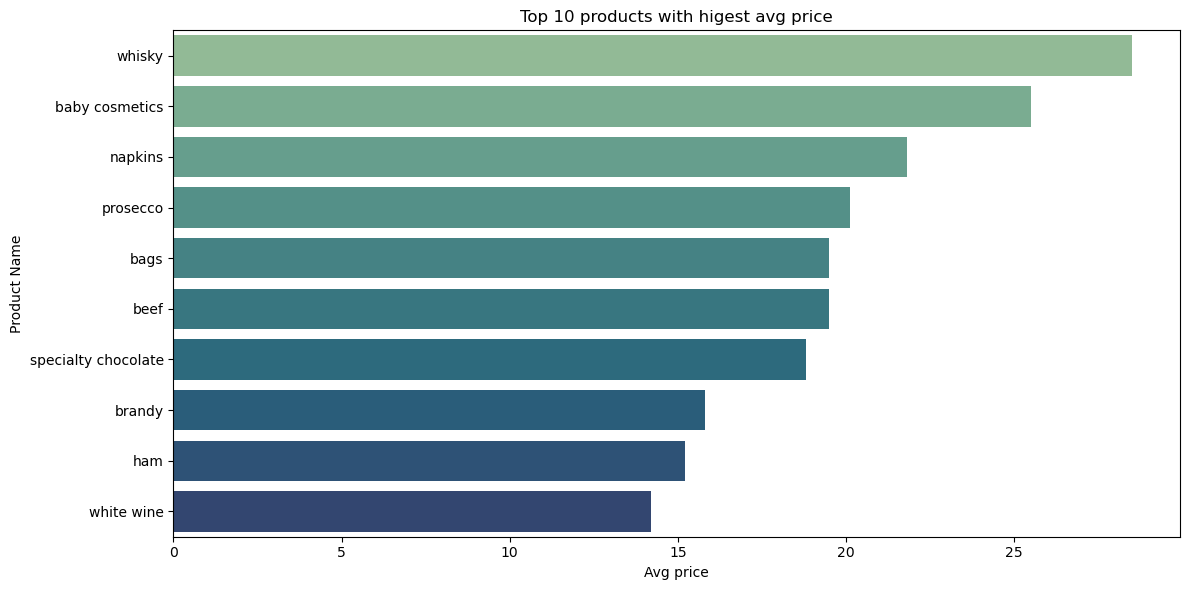

Top-selling products 
                     price
productName               
whisky                28.5
baby cosmetics        25.5
napkins               21.8
prosecco              20.1
bags                  19.5
beef                  19.5
specialty chocolate   18.8
brandy                15.8
ham                   15.2
white wine            14.2 

Least-selling products
                       price
productName                 
white bread              0.3
bottled water            0.5
chewing gum              0.5
salty snack              0.5
Instant food products    0.6
salt                     0.7
brown bread              0.8
other vegetables         0.8
soda                     0.8
snack products           0.9


In [219]:
bar_h(top_products_sold, 'items', 'productName','Top 10 products by items sold', 'Total items sold', 'Product Name' )
print(f"Top-selling products \n{top_products_sold} \n\nLeast-selling products\n{bottom_products_sold}")

bar_h(top_products_revenue, 'sales', 'productName','Top 10 products by revenue', 'Revenue', 'Product Name' )
print(f"Top-selling products \n{top_products_revenue} \n\nLeast-selling products\n{bottom_products_revenue}")


bar_h(top_products_price, 'price', 'productName','Top 10 products with higest avg price', 'Avg price', 'Product Name' )
print(f"Top-selling products \n{top_products_price} \n\nLeast-selling products\n{bottom_products_price}")


## Customer Level

In [220]:
top_customer_sold = df.groupby('Member_number').agg(
            {'items': 'sum'}).sort_values(by = 'items', ascending=False).reset_index().head(10)
top_customer_revenue = df.groupby('Member_number').agg(
            {'sales': 'sum'}).sort_values(by = 'sales', ascending=False).reset_index().head(10)
avg_customer_price = df.groupby('Member_number').agg(
            {'price': 'mean'}).sort_values(by = 'price', ascending=False).reset_index().head(10)

In [221]:
top_customer_sold['Member_number'] = top_customer_sold['Member_number'].astype(str)
top_customer_revenue['Member_number'] = top_customer_revenue['Member_number'].astype(str)
avg_customer_price['Member_number'] = top_customer_revenue['Member_number'].astype(str)

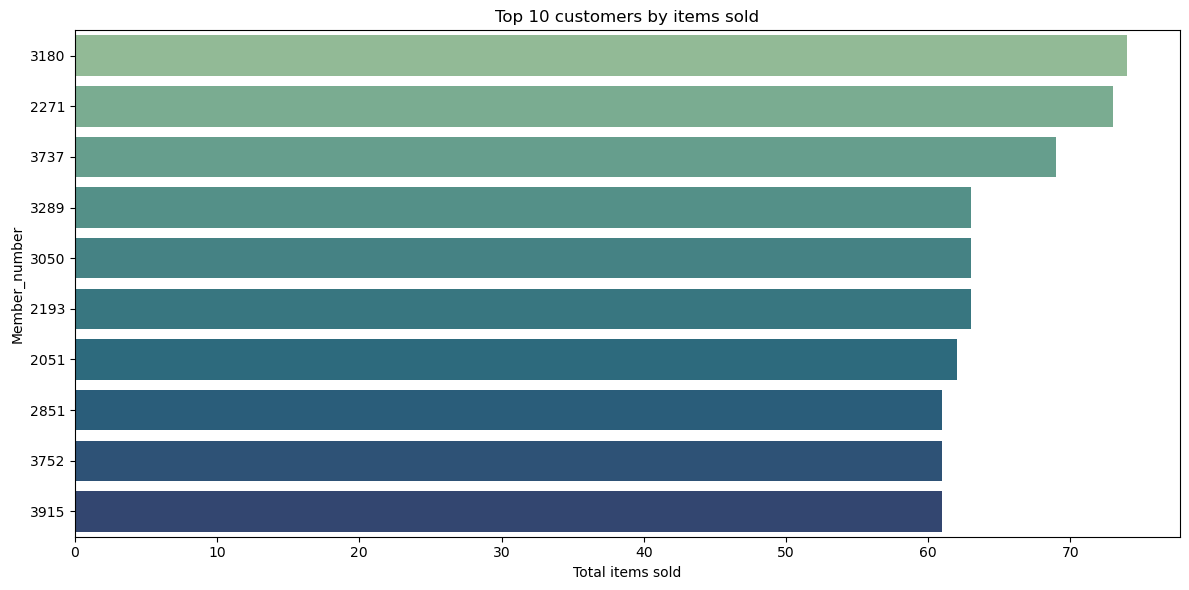

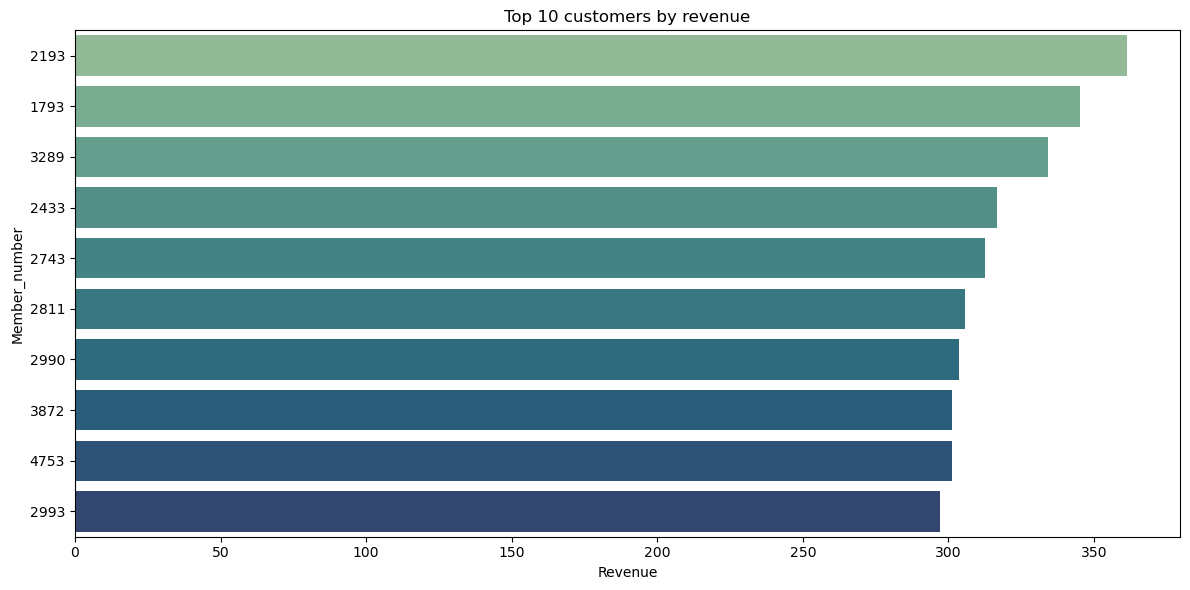

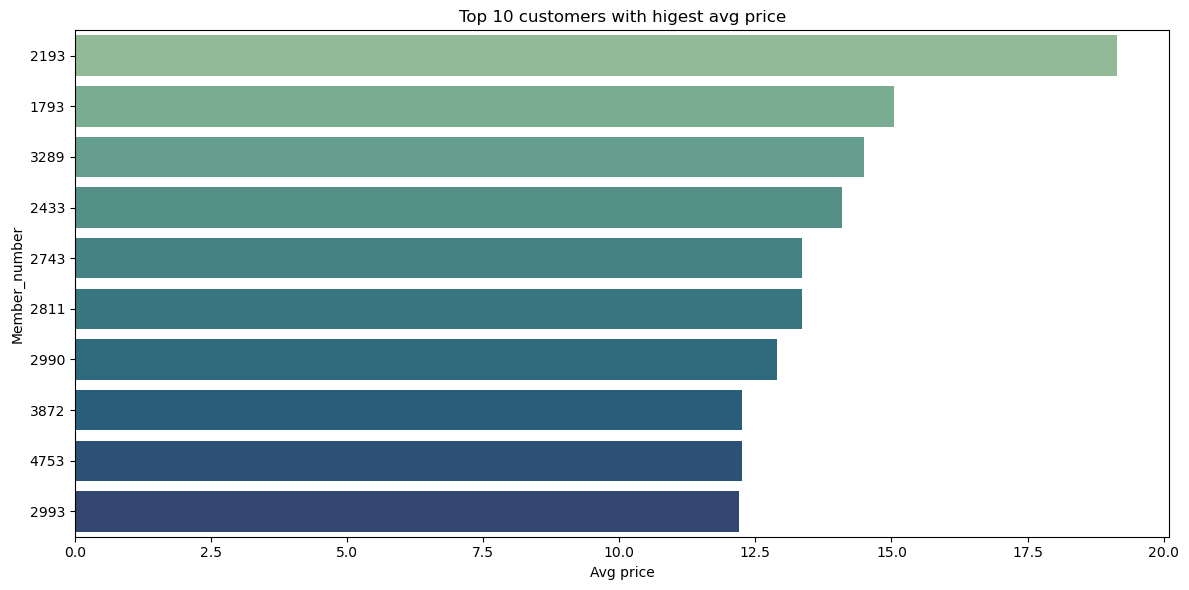

In [222]:
bar_h(top_customer_sold, 'items', 'Member_number','Top 10 customers by items sold', 'Total items sold', 'Member_number' )
bar_h(top_customer_revenue, 'sales', 'Member_number','Top 10 customers by revenue', 'Revenue', 'Member_number' )
bar_h(avg_customer_price, 'price', 'Member_number','Top 10 customers with higest avg price', 'Avg price', 'Member_number' )

# Calculate RFM

In [223]:
max_date = df['Date'].max()

Recency = lambda x : (max_date - x.max()).days
Frequency  = lambda x: x.count()
Monetary = lambda x : round(sum(x), 2)


df_RFM = df.groupby('Member_number').agg({'Date': Recency,
                                        'Member_number': Frequency,
                                        'sales': Monetary })

# Rename the columns of DataFrame
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
# Descending Sorting
df_RFM = df_RFM.sort_values('Monetary', ascending=False)

df_RFM.head()                                      

,Recency,Frequency,Monetary
Member_number,,,
2193,91,27,361.45
1793,26,25,345.10
3289,4,29,334.15
2433,3,30,316.81
2743,142,17,312.46


In [224]:
df_RFM.shape

(3898, 3)

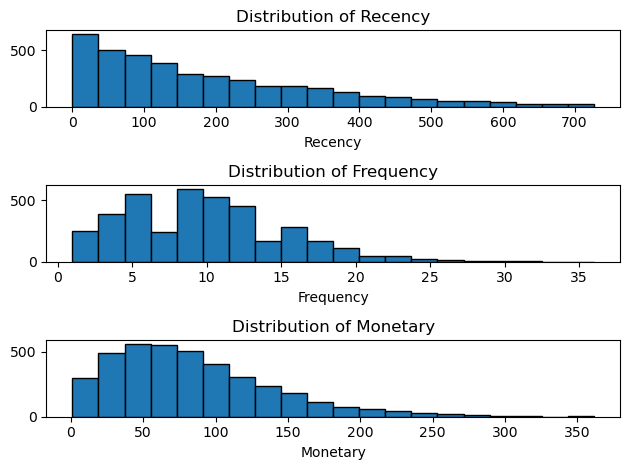

In [225]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(df_RFM['Recency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(df_RFM['Frequency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(df_RFM['Monetary'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

In [226]:
# Create labels for Recency, Frequency, Monetary
r_labels = range(4, 0, -1) 
f_labels = range(1, 5)
m_labels = range(1, 5)

In [227]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)

m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [228]:
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
Member_number,,,,,,
2193,91,27,361.45,3,4,4
1793,26,25,345.10,4,4,4
3289,4,29,334.15,4,4,4
2433,3,30,316.81,4,4,4
2743,142,17,312.46,2,4,4


In [229]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)

In [230]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
Member_number,,,,,,,
2193,91,27,361.45,3,4,4,344
1793,26,25,345.10,4,4,4,444
3289,4,29,334.15,4,4,4,444
2433,3,30,316.81,4,4,4,444
2743,142,17,312.46,2,4,4,244


In [231]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

60


In [232]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Member_number,,,,,,,,
2193,91,27,361.45,3,4,4,344,11
1793,26,25,345.10,4,4,4,444,12
3289,4,29,334.15,4,4,4,444,12
2433,3,30,316.81,4,4,4,444,12
2743,142,17,312.46,2,4,4,244,10


In [233]:
df_RFM.reset_index().to_csv('df_RFM.csv', index= False)

In [234]:
df_RFM['RFM_Score'].unique()

array([11, 12, 10,  9,  8,  7,  6,  5,  4,  3])